Welcome to the SPE Geothermal Experience data modeling bootcamp, otherwise titled
## A very inexpensive and completely non-exhaustive introduction to seven data science techniques for fun and profit in the real world

## 0.1 Import Default Dependencies 

This chunk imports dependencies that are in the DataCamp Workspace by default (i.e. you don't need to specially install them). We are going to use the following dependencies in this notebook.

In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Special Installs

We are going to use a couple packages not available by default, and install them here. Datacamp has done an amazing job of helping these dependencies to work so kudos to them. This takes a little bit of finesse, but I believe I've picked an older package set that should work well on the workspace.

The first package is geopandas (for geospatial visualization & analysis)
The second package is pandas profiling (for being a EDA genius)

In [ ]:
# geopandas
!pip install geopandas==0.8.0

In [ ]:
# pandas profiling
!pip install bottleneck==1.2.1 --upgrade
!pip install pandas-profiling==2.8.0

In [ ]:
!pip install geovoronoi

In [5]:
# import the packages
import geopandas as gpd
from pandas_profiling import ProfileReport
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# Let's Get to Work

This bootcamp is going to cover seven principles I think you might get some value out of:
1. Know Your Scale of Observation and Modeling
2. Subsurface Data has a Geospatial Component
3. Profile Your Data
4. Baseline Models Save the Day
5. Know Your Model Types
6. Cross Validation is King
7. Loss Metrics and Preprocessing are Machine Learning 

First, we need some data. I've been working on a problem with well logs (which I can't provide sorry) and rock mechanics tests - trying to see what the best framework is to link well logs to the lab tests across the Duvernay Formation. My live code and data can be found here:
https://github.com/ScottHMcKean/duvernay_geomech_model

We are going to work with four relatively clean files:
1. facies_values.csv
2. merged_tests_w_residual.csv
3. facies_values.geojson
4. study_dv_bounds.GeoJSON

## 1. Know Your Scale of Observation and Modeling
Machine learning only works if we have the same scale of observation. Compare a well log (depth scale) to a map scale problem. In order to build a good model, you have to have observations on the same scale. In our dataset, I've upscaled logs in the Duvernay based on gamma ray signatures to produce a single subset of shale and carbonate values at each location. This allows me to work in a map view and do most of the above referenced study.

Even in deep learning problems, the input generally needs to be a very consistent sequence or matrix of values, so you must know the scale of your observations. For example:
- How many dimensions (xy, xyz, xyzt)?
- How do you get the data to the same scale?
- What level is a decision being made from? 
- How big is your log / map / image / time series / text sequence etc...

Let's compare the previous workshop data to our data and discuss similarities

In [6]:
facies_data = gpd.read_file('./data/facies_data.GeoJSON')
study_bounds = gpd.read_file("./data/study_dv_bounds.GeoJSON")
display(facies_data)

,uwi,facies,mean_elev_masl,rows,thickness,rhob_mean,rhob_sd,dtc_mean,dtc_sd,dts_mean,dts_sd,gr_mean,gr_sd,latitude,longitude,kbe,ground_elev,geometry
0,100010506418W500,dv_carb,-2079.850,120,11.90,2705.371366,18.678541,53.862733,5.273687,NaN,NaN,34.101703,11.692381,54.504754,-116.677433,786.1,781.2,POINT (520887.472 6039731.073)
1,100010506418W500,dv_shale,-2057.100,335,33.40,2587.148364,55.855642,66.658810,4.275123,NaN,NaN,116.626896,33.474055,54.504754,-116.677433,786.1,781.2,POINT (520887.472 6039731.073)
2,100010506518W500,dv_carb,-2040.900,147,14.60,2687.957086,18.143394,192.072516,15.272949,358.529875,30.908213,36.115538,9.815519,54.591610,-116.678915,776.7,769.8,POINT (520747.388 6049395.109)
3,100010506518W500,dv_shale,-2018.350,304,30.30,2579.103929,68.152077,243.442625,14.801307,417.410413,45.396468,88.905674,16.308970,54.591610,-116.678915,776.7,769.8,POINT (520747.388 6049395.109)
4,100011806117W500,dv_carb,-2124.175,475,11.85,2716.228163,18.575439,187.936457,16.074762,342.732430,22.435699,57.115070,26.988237,54.271345,-116.531955,967.0,960.7,POINT (530480.162 6013813.387)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,103011606324W500,dv_carb,-2684.450,84,8.30,2713.573462,19.482534,173.256061,11.081089,322.027976,17.242774,36.170985,10.117352,54.444943,-117.558016,866.6,859.0,POINT (463813.658 6033171.436)
179,103011606324W500,dv_shale,-2663.650,332,33.10,2557.459156,44.780180,237.231069,10.605535,388.069624,19.066190,163.312719,43.048974,54.444943,-117.558016,866.6,859.0,POINT (463813.658 6033171.436)
180,103082506018W500,dv_shale,-2152.900,455,45.40,2585.017537,85.213554,236.374378,19.392751,387.697355,20.288908,125.173595,46.366350,54.216867,-116.555568,973.1,967.7,POINT (528980.595 6007742.009)
181,103162506119W500,dv_carb,-2210.550,132,13.10,2712.721677,14.793023,NaN,NaN,NaN,NaN,39.048966,10.718732,54.309144,-116.703362,927.1,922.2,POINT (519300.106 6017958.639)


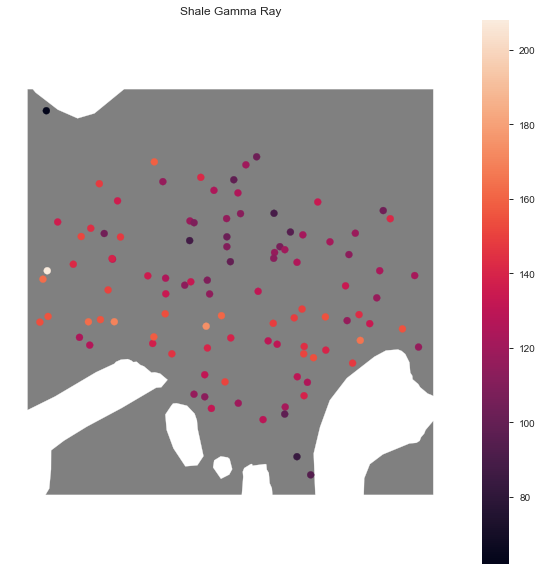

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
study_bounds.plot(ax=ax, color='gray')
facies_data.query("facies=='dv_shale'").plot(ax=ax, column='gr_mean', legend=True)
ax.axis('off')
plt.title('Shale Gamma Ray')
plt.axis('equal')
plt.show()

## 2. Subsurface Data has a Geospatial Component
Some of the most important observations come from spatial cross validation and residual analysis in space. I love the geopandas package for working with geospatial data: https://geopandas.org/index.html

Once you get geospatial data, you can do some amazing things... like Voronoi tesselation.
https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134
https://pypi.org/project/geovoronoi/

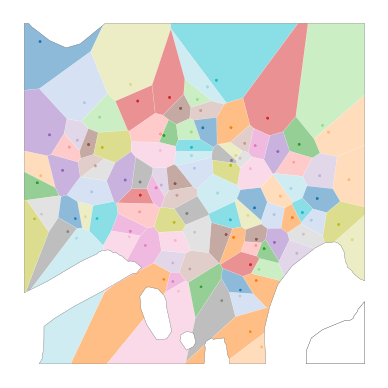

In [8]:
from shapely.ops import cascaded_union

boundary_shape = cascaded_union(study_bounds.geometry)
coords = points_to_coords(facies_data.geometry)

region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)
plt.tight_layout()
plt.show()

Or quickly calculate a the distance between all wells and ask questions like what is the closest well to each other well?

In [ ]:
facies_data.distance(facies_data)

In [10]:
adjacent_wells = []
for i, row in facies_data.query("facies=='dv_shale'").iterrows():
    this_uwi = row.uwi
    dist = facies_data.distance(row.geometry)
    uwis = facies_data.uwi[dist[dist>0].index].values
    out = pd.DataFrame({
        'uwi':this_uwi,
        'adjacent_wells':uwis,
        'distance':dist[dist>0].values
    })
    adjacent_wells.append(out)
    
well_distance_df = pd.concat(adjacent_wells)

In [11]:
display(well_distance_df)

,uwi,adjacent_wells,distance
0,100010506418W500,100010506518W500,9665.051293
1,100010506418W500,100010506518W500,9665.051293
2,100010506418W500,100011806117W500,27635.957680
3,100010506418W500,100011806117W500,27635.957680
4,100010506418W500,100012806123W500,50946.474275
...,...,...,...
176,103162506119W500,102020906220W500,15684.852613
177,103162506119W500,102110806224W500,56435.763501
178,103162506119W500,103011606324W500,57534.121551
179,103162506119W500,103011606324W500,57534.121551


In [ ]:
well_distance_df.loc[well_distance_df.groupby('uwi').distance.idxmin()]

## 3. Profile Your Data
Model types have assumptions and respond to edge cases very differently - know about skewed data, missing values, zeros, and uninformative features. Here is a rough checklist to think about
- Lots of zero values 
- Heavily skewed distributions
- Uninformative features
- Lots of missing values
- Highly correlated features
- Interactions

Evaluate correlation and mutual information with or without models because after all, machine learning is mostly just building a model of multi variate correlated features mapped to a target. Luckily Pandas Profiling does this for you!

In [13]:
geomech_df = pd.read_csv('./data/merged_tests_w_residual.csv')

In [15]:
profile = ProfileReport(geomech_df, title="Facies Data")
#profile.to_notebook_iframe()

## 4. Baseline Models Save the Day
You learn a lot from simple models and from moving up the bias-variance curve on your own. I'll explain bias and variance, and then talk about baseline thinking, or setting a very simple baseline to start from. For this example, let's do some very simple baseline models to set the stage for model comparisons.

So we still go through the basics
- Select relevant features
- Scale our features https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html#sklearn.preprocessing.scale
- Train/test split https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- Fit a linear regression model
- Fit an even simpler baseline model
- Do feature importance
- Compute a couple loss metric https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [16]:
geomech_df.columns

Index(['round_depth', 'orientation', 'confining_pressure', 'peak_stress_dev',
       'residual_stress_dev', 'youngs_modulus', 'poisson_ratio',
       'bulk_density', 'group', 'well', 'deviatoric_stress', 'pred_vp',
       'se_vp', 'pred_vs', 'se_vs', 'se_vp_per', 'se_vs_per'],
      dtype='object')

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# get target and features
X = geomech_df[['confining_pressure','bulk_density','deviatoric_stress', 'pred_vp','pred_vs']]
y = geomech_df.youngs_modulus

# scale our features
X_norm = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=3)

# linear regression
reg = LinearRegression().fit(X_train, y_train)

In [18]:
print(X.columns)
print(reg.coef_)
print(reg.intercept_)

Index(['confining_pressure', 'bulk_density', 'deviatoric_stress', 'pred_vp',
       'pred_vs'],
      dtype='object')
[-1.0871115   0.89718957  2.59182793  6.27157397  4.61633919]
32.924585199316134


Train R2, MAE, RMSE:
0.8673833989478411
3.953590574074837
4.964198278405101
Test R2, MAE, RMSE:
0.786175822196038
4.306283701969137
5.50975395203057


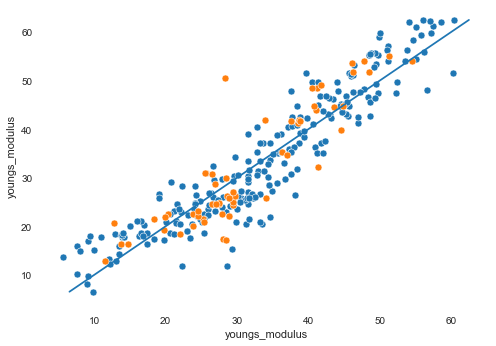

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# train score
print('Train R2, MAE, RMSE:')
y_train_pred = reg.predict(X_train)
print(reg.score(X_train, y_train))
print(mean_absolute_error(y_train, y_train_pred))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

# test score
print('Test R2, MAE, RMSE:')
y_test_pred = reg.predict(X_test)
print(reg.score(X_test, y_test)) #default regression loss function is R2
print(mean_absolute_error(y_test, y_test_pred))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# residual plot
fig, ax = plt.subplots()
sns.scatterplot(y_train_pred, y_train, ax=ax)
sns.scatterplot(y_test_pred, y_test, ax=ax)
sns.lineplot(y_train, y_train, ax=ax)
plt.show()

Test R2, MAE, RMSE:
-0.0006144416109969963
11.686106572745762
13.635892116466506


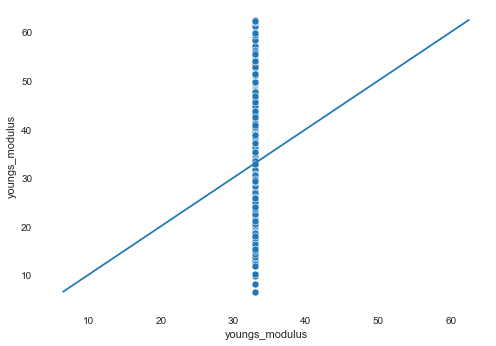

In [20]:
# what about an even simpler model?
dumb_guess_train = y_train.copy()
dumb_guess_train[:] = y.mean()

# test score
print('Test R2, MAE, RMSE:')
print(r2_score(y_train, dumb_guess_train))
print(mean_absolute_error(y_train, dumb_guess_train))
print(np.sqrt(mean_squared_error(y_train, dumb_guess_train)))

# residual plot
fig, ax = plt.subplots()
sns.scatterplot(dumb_guess_train, y_train, ax=ax)
sns.lineplot(y_train, y_train, ax=ax)
plt.show()

## 5. Know Your Model Types
Let’s talk about the basic model classes that you might consider. Sklearn has a LOT of models to choose from, and beyond models there are whole pipelines to consider. Just check out the API Classes: https://scikit-learn.org/stable/modules/classes.html#

Look at 'choosing the right estimator'
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

For regression, we can cover the following main types - there is pretty much a direct analog for classification problems, with the slight exception of linear regression which needs to be converted into a logistic regression function.

1. Linear models (classic, ridge, lasso, elasticnet)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV

2. Tree models & tree ensembles (decision tree, random forest, gradient boosting)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

3. Neural networks (baby deep learning models)

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

4. Nearest Neighbours (direct prediction)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor

5. Support Vector Machines (response surface)

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR

I'll walk through a random forest example below, but the general workflow I think about is:
1. Pick a model
2. Search to find out about its assumptions
3. Search to find decent hyperparmeter tuning ranges and important hyperparameters
4. Setup a cross-validated hyperparameter tuning algorithm and try it out
5. Evaluate residuals and feature importance

So for random forest

1. Pick a model
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

2. Search to find out about its assumptions
Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001
https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb
https://medium.com/neptune-ai/random-forest-regression-when-does-it-fail-and-why-926cc3a4ec

3. Search to find decent hyperparmeter tuning ranges and important hyperparameters
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

4. Setup a cross-validated hyperparameter tuning algorithm and try it out
5. Evaluate residuals and feature importance

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# default RF regressor
rf = RandomForestRegressor(random_state = 42)
print('\n Default Hyperparameters')
print(rf.get_params())

# Thanks Will Koehrsen
# towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print('\n Our Grid Search params')
print(random_grid)


 Default Hyperparameters
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

 Our Grid Search params
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [22]:
# Use the random grid to search for best hyperparameters

# First create the base model (called an estimator in sklearn) to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 50, 
    cv = 3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [23]:
# print the best hyperparameters
rf_tuned = rf_random.best_estimator_
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30}

Train R2, MAE, RMSE:
0.8673833989478411
1.2482981120185186
1.8182594585583653
Test R2, MAE, RMSE:
0.786175822196038
3.0751713852459015
4.922588889786971


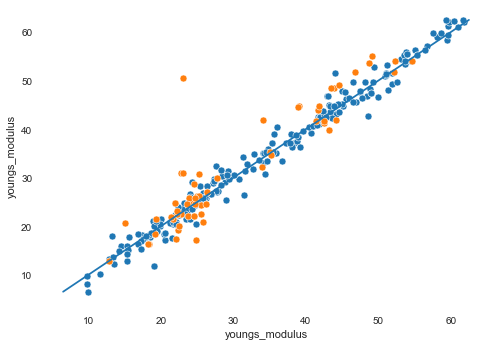

In [24]:
base_rf_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_rf_model.fit(X_train, y_train)

# train score
print('Train R2, MAE, RMSE:')
y_train_pred = base_rf_model.predict(X_train)
print(reg.score(X_train, y_train))
print(mean_absolute_error(y_train, y_train_pred))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

# test score
print('Test R2, MAE, RMSE:')
y_test_pred = base_rf_model.predict(X_test)
print(reg.score(X_test, y_test)) #default regression loss function is R2
print(mean_absolute_error(y_test, y_test_pred))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# residual plot
fig, ax = plt.subplots()
sns.scatterplot(y_train_pred, y_train, ax=ax)
sns.scatterplot(y_test_pred, y_test, ax=ax)
sns.lineplot(y_train, y_train, ax=ax)
plt.show()

Train R2, MAE, RMSE:
0.8673833989478411
1.493553632618339
1.9881019582812955
Test R2, MAE, RMSE:
0.786175822196038
3.0723313591371006
4.750556619258759


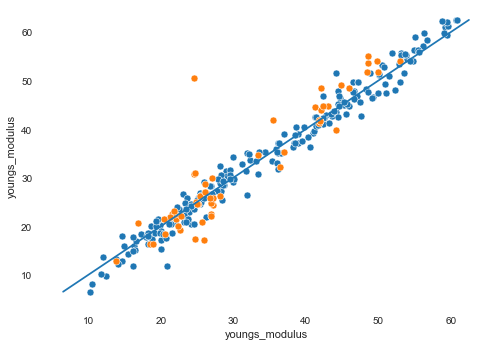

In [25]:
# train score
print('Train R2, MAE, RMSE:')
y_train_pred = rf_tuned.predict(X_train)
print(reg.score(X_train, y_train))
print(mean_absolute_error(y_train, y_train_pred))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

# test score
print('Test R2, MAE, RMSE:')
y_test_pred = rf_tuned.predict(X_test)
print(reg.score(X_test, y_test)) #default regression loss function is R2
print(mean_absolute_error(y_test, y_test_pred))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# residual plot
fig, ax = plt.subplots()
sns.scatterplot(y_train_pred, y_train, ax=ax)
sns.scatterplot(y_test_pred, y_test, ax=ax)
sns.lineplot(y_train, y_train, ax=ax)
plt.show()

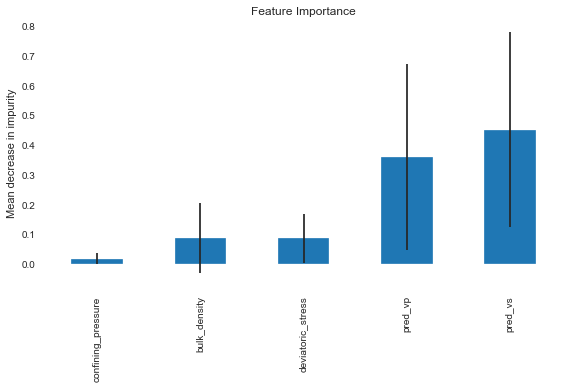

In [26]:
# Feature importance
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

feat_names = X.columns.values
importances = rf_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feat_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 6. Cross Validation is King
We want to learn the rules of nature, not memorize every example. Good cross-validation helps tremendously with this. Definitely read this: https://scikit-learn.org/stable/modules/cross_validation.html. But here are the main steps to understand cross-validation:

1. We always have a train and a test set! This is the only way to avoid making horrendous mistakes, so unless you have nearly no data and are using statistically robust (i.e. not black box, maximum likelihood based) methods, have a test set.

2. You tune on this test set, so if you are doing a lot of hyperparameter tuning (https://scikit-learn.org/stable/modules/grid_search.html), you can actually start to 'game' and overfit the test set. So if you have enough data to spare, it is also worthwhile to have a validation set - something you set aside and NEVER look at until your whole DS process is done. Read some of Cassie Kozyrkov's articles about this.
https://towardsdatascience.com/training-validation-and-test-phases-in-ai-explained-in-a-way-youll-never-forget-744be50154e8

3. So, given the above, we have a hierarchical framework to test our modeling - test/train/validate + cross-validation within the train set. 

In [27]:
# let's do some setup to show how this is done
# Hold this forever
validation = geomech_df.sample(frac=0.1)
X_val = validation[['confining_pressure','bulk_density','deviatoric_stress', 'pred_vp','pred_vs']]
y_val = validation.youngs_modulus

# Cross validate and tune on this
ml_df = geomech_df.drop(validation.index, errors="ignore")
X_ml = ml_df[['confining_pressure','bulk_density','deviatoric_stress', 'pred_vp','pred_vs']]
y_ml = ml_df.youngs_modulus
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=3)

# We actually already covered CV above!

There are also a couple different ways to use cross validation in sklearn.

1. Use cross_val_score 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

2. Use cross_validate

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

3. Use CV enabled hyperparameter search

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html

4. Use CV-integrated estimators

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

## 7. Loss Metrics and Preprocessing are Machine Learning 
They change your outcome, sometimes considerably. Know if you have heavy tails and how loss metrics deal with them.

Let's put all this together in an sklearn pipeline. Now witness the firepower of this fully armed and operational battle station... and try not to get too confused.

So, modeling generally follows three big steps once you understand the problem you are trying to solve and have your data ready for the magic black box. First, we preprocess our data. Second, we select an estimator. Finally, we fit and evaluate that estimator in a robust way. The brilliant people that develop SKLearn understand this, and so have developed pipelines to encompass all those steps in a repeatable, cross-validatable way.
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Also, you can cross validate over pipelines! Let's have a look.

I've stolen this example mostly from https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf, its a good article about pipelines and covers the basics well..

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = ml_df[['confining_pressure','bulk_density','deviatoric_stress', 'pred_vp','pred_vs','orientation']].select_dtypes(include=['int64', 'float64']).columns
categorical_features = ml_df[['confining_pressure','bulk_density','deviatoric_stress', 'pred_vp','pred_vs','orientation']].select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor())])

param_grid = { 
    'regressor__n_estimators': [200, 500],
    'regressor__max_depth' : [10, 20, 30, 50, 100, 200]
    }

scoring = {
    'MAE': make_scorer(mean_absolute_error), 
    'RMSE': make_scorer(mean_squared_error), 
    'R2': make_scorer(r2_score)
    }

In [29]:
CV = GridSearchCV(rf_pipe, param_grid, scoring=scoring, refit='MAE', n_jobs= -1)

mae_results = CV.fit(
    ml_df[['confining_pressure','bulk_density','deviatoric_stress', 'pred_vp','pred_vs','orientation']],
    ml_df.youngs_modulus
)
print(CV.best_params_)  
print(CV.best_score_)

{'regressor__max_depth': 50, 'regressor__n_estimators': 200}
3.7762864685261626


In [30]:
# you can see our 'estimator' has become WAY more complex now - it is the whole pipeline!
CV.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['confining_pressure', 'bulk_density', 'deviatoric_stress', 'pred_vp',
       'pred_vs'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                     

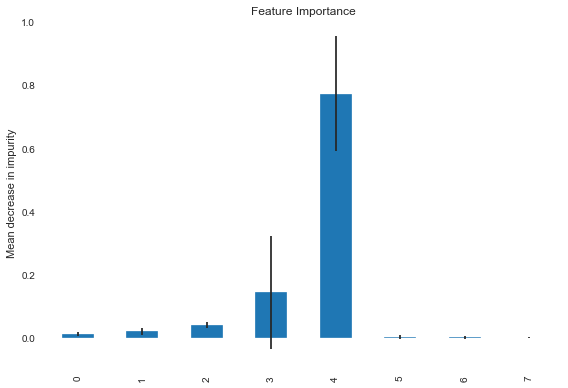

In [31]:
mae_tuned = CV.best_estimator_['regressor']
importances = mae_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in mae_tuned.estimators_], axis=0)
forest_importances = pd.Series(importances)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [35]:
CV = GridSearchCV(rf_pipe, param_grid, scoring=scoring, refit='RMSE', n_jobs= -1)

mae_results = CV.fit(
    ml_df[['confining_pressure','bulk_density','deviatoric_stress', 'pred_vp','pred_vs','orientation']],
    ml_df.youngs_modulus
)
print(CV.best_params_)
print(CV.best_score_)

{'regressor__max_depth': 50, 'regressor__n_estimators': 200}
25.220192635927532


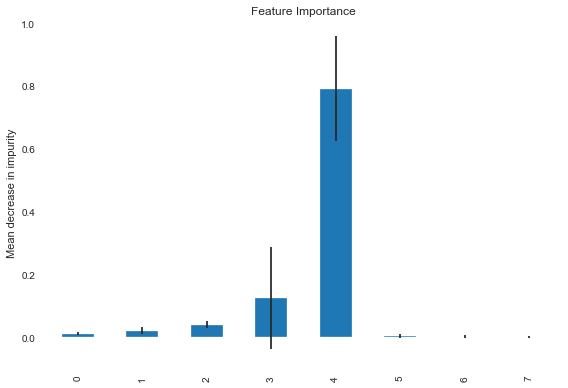

In [36]:
mae_tuned = CV.best_estimator_['regressor']
importances = mae_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in mae_tuned.estimators_], axis=0)
forest_importances = pd.Series(importances)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()